In [21]:
from hydra import initialize, compose
import json
from rdkit import Chem
from pathlib import Path
from ergochemics.draw import draw_reaction, draw_molecule
from ergochemics.mapping import rc_to_nest
from IPython.display import SVG
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

In [22]:
with initialize(version_base=None, config_path="./conf/filepaths"):
    filepaths = compose(config_name="filepaths")

In [23]:
entries = {}
for i in range(0, 11):
    with open(Path(filepaths.raw_mcsa) / f"entries_{i}.json", "r") as f:
        entries = {**entries, **json.load(f)}

mech_ct = 0
detailed_ct = 0
for id, entry in entries.items():
    mechanisms = entry['reaction']['mechanisms']
    if mechanisms is None:
        continue

    for mech in mechanisms:
        mech_ct += 1
        if mech['is_detailed']:
            detailed_ct += 1

print(f"Total number of mechanisms: {mech_ct}")
print(f"Number of detailed mechanisms: {detailed_ct} ({detailed_ct/mech_ct*100:.2f}%)")
print(f"Total number of entries: {len(entries)}")


Total number of mechanisms: 1166
Number of detailed mechanisms: 887 (76.07%)
Total number of entries: 1003


In [24]:
mech_df = pd.read_csv(Path(filepaths.interim_data) / 'mcsa' / 'mech_labeled_reactions.csv', sep=",")
mech_df['mech_atoms'] = mech_df['mech_atoms'].apply(lambda x: rc_to_nest(x))
n_unique = len(set(mech_df[["entry_id", "mechanism_id"]].apply(tuple, axis=1)))
print(f"{n_unique/detailed_ct*100:.2f}% of detailed mechanisms have been processed")
mech_df.head(10)

15.90% of detailed mechanisms have been processed


,entry_id,mechanism_id,smarts,mech_atoms,enzyme_name,uniprot_id,ec
0,2,2,[OH2:1].[*:5][C:4](=[O:6])[NH:3][CH:2]1[C:7](=...,"(((1,), (7, 8, 9)), ((),))",beta-lactamase (Class A),P62593,3.5.2.6
1,2,1,[OH2:1].[*:5][C:4](=[O:6])[NH:3][CH:2]1[C:7](=...,"(((1,), (7, 8, 9)), ((),))",beta-lactamase (Class A),P62593,3.5.2.6
2,12,2,[NH2:6][CH2:5][CH2:4][CH2:3][CH:2]([NH3+:1])[C...,"(((6,), (11, 12, 14)), ((),))",ornithine carbamoyltransferase,P00480,2.1.3.3
3,12,1,[NH2:6][CH2:5][CH2:4][CH2:3][CH:2]([NH3+:1])[C...,"(((6,), (11, 12, 14)), ((),))",ornithine carbamoyltransferase,P00480,2.1.3.3
4,16,1,[OH-:1].[*:6][C:4](=[O:5])[NH:3][CH:2]1[C:7](=...,"(((1,), (7, 8, 9)), ((),))",beta-lactamase (Class B1),P04190,3.5.2.6
5,22,1,[NH3+:6][CH2:5][CH2:4][c:3]1[cH:2][nH:1][c:8]2...,"(((6,), (46, 47, 48)), ((),))",aralkylamine N-acetyltransferase,Q29495,2.3.1.87
6,31,1,[O:18]=[c:17]1[cH:19][cH:20][n:1]([CH:2]2[CH2:...,"(((17, 18, 19, 20), (27, 28, 29, 30)), ((),))",thymidylate synthase,P00469,2.1.1.45
7,31,2,[O:18]=[c:17]1[cH:19][cH:20][n:1]([CH:2]2[CH2:...,"(((19, 20), (27, 28, 29, 30)), ((),))",thymidylate synthase,P00469,2.1.1.45
8,49,1,[NH3+:3][CH:2]([CH2:1][c:7]1[cH:8][nH:9][cH:10...,"(((2, 3, 4, 6),), ((),))",histidine decarboxylase,P00862,4.1.1.22
9,50,3,[O:6]=[C:4]([O-:5])[c:3]1[cH:7][c:8](=[O:9])[n...,"(((3, 4, 5, 7),), ((),))",orotidine-5'-phosphate decarboxylase,P25971,4.1.1.23


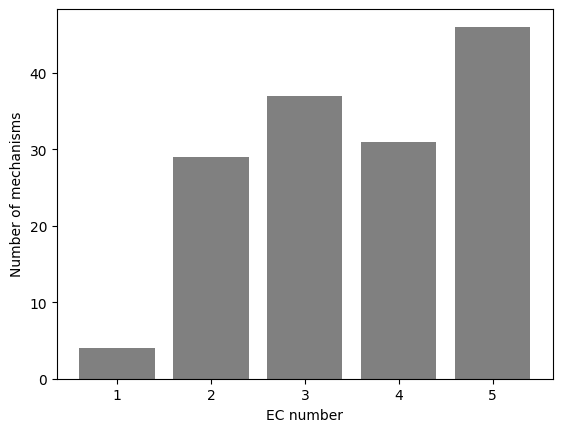

In [25]:
ecs = []
n_digits = 1
for eid in mech_df['entry_id']:
    ecs.append(entries[str(eid)]['reaction']['ec'])

ec_trunc = [elt[:n_digits] for elt in ecs]
ec_counts = Counter(ec_trunc)
ec_counts = sorted(ec_counts.items(), key=lambda x: x[0])

fig, ax = plt.subplots()
x = [i for i in range(len(ec_counts))]
ax.bar(x, [elt[1] for elt in ec_counts], color='gray')
ax.set_xticks(x)
ax.set_xticklabels([elt[0] for elt in ec_counts])
ax.set_xlabel('EC number')
ax.set_ylabel('Number of mechanisms')
plt.show()

In [26]:
def display_mech_labeled_rxn(entry_id: int, de_am: bool = False):
    sma2mol = lambda x : Chem.MolFromSmiles(Chem.MolToSmiles(Chem.MolFromSmarts(x)))

    # Get the reaction
    smarts = mech_df.loc[mech_df['entry_id'] == entry_id, 'smarts'].iloc[0]

    these_mechs = mech_df.loc[mech_df['entry_id'] == entry_id]
    for _, row in these_mechs.iterrows():
        print(f"Mechanism: #{row['mechanism_id']}")
        smarts = row['smarts']
        lhs = [sma2mol(elt) for elt in smarts.split('>>')[0].split('.')]
        mech_atom_map_nums = row['mech_atoms'][0]

        # Get atoms involved in the reaction
        involved_atoms = []
        for ams, mol in zip(mech_atom_map_nums, lhs):
            involved_atoms.append([atom.GetIdx() for atom in mol.GetAtoms() if atom.GetAtomMapNum() in ams])

        
        if de_am:
            for mol in lhs:
                for atom in mol.GetAtoms():
                    atom.SetAtomMapNum(0)

            smarts = '.'.join([Chem.MolToSmiles(mol) for mol in lhs]) + '>>' + smarts.split('>>')[1]
        
        # Display
        display(SVG(draw_reaction(smarts, sub_img_size=(150, 100))))
        for i, rct in enumerate(lhs):
            display(SVG(draw_molecule(rct, size=(300, 200), highlight_atoms=involved_atoms[i], draw_options={"addAtomIndices": False})))

In [27]:
display_mech_labeled_rxn(711)

IndexError: single positional indexer is out-of-bounds

Mechanism: #1


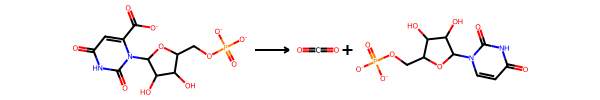

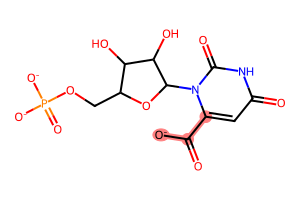

Mechanism: #3


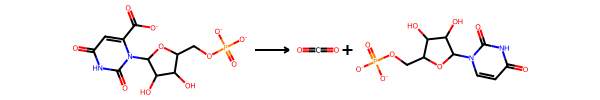

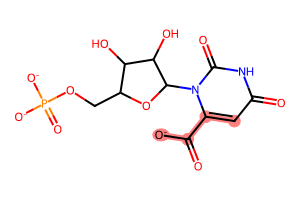

Mechanism: #2


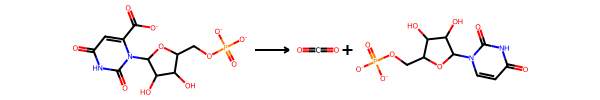

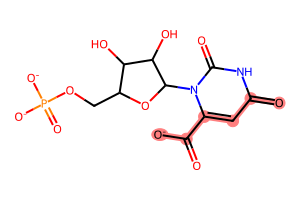

In [ ]:
display_mech_labeled_rxn(50)

Mechanism: #1


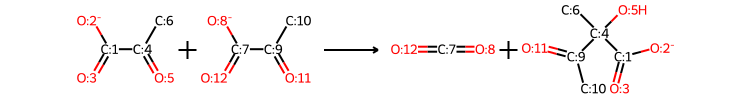

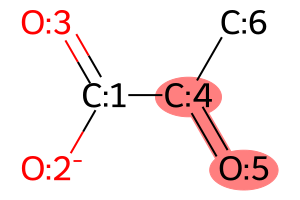

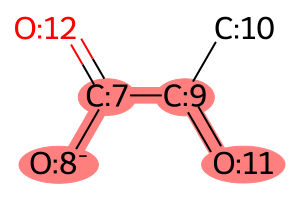

In [ ]:
display_mech_labeled_rxn(722, de_am=False)

Mechanism: #1


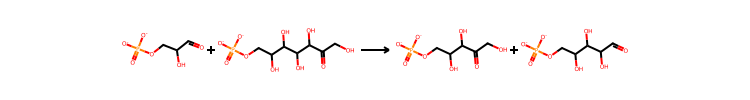

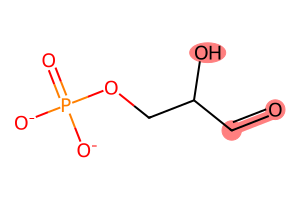

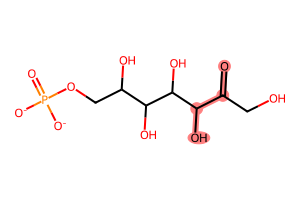

In [ ]:
display_mech_labeled_rxn(219)

Mechanism: #2


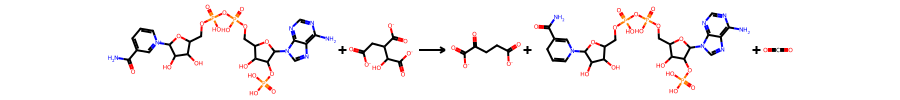

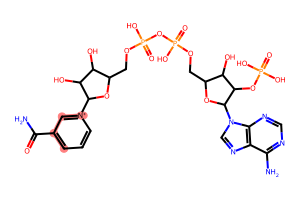

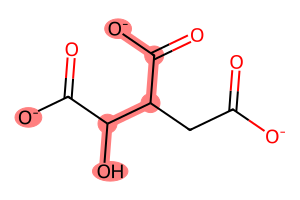

Mechanism: #1


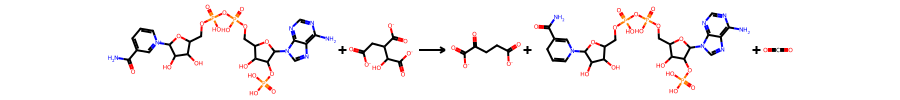

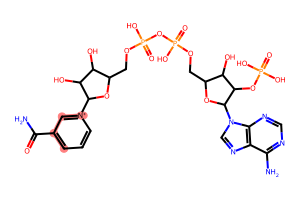

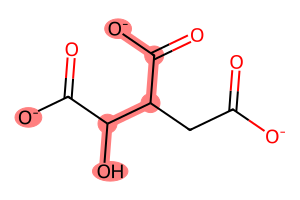

Mechanism: #3


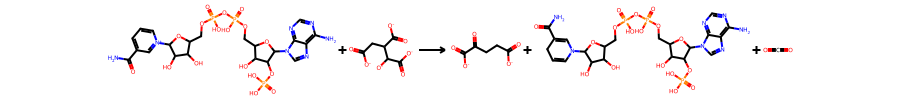

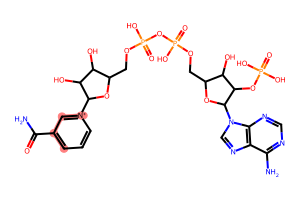

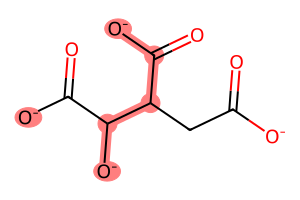

In [ ]:
display_mech_labeled_rxn(7)

Mechanism: #2


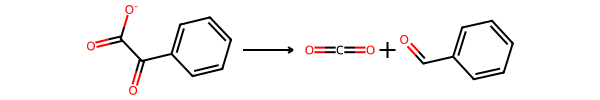

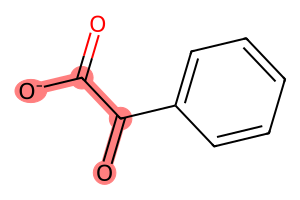

Mechanism: #3


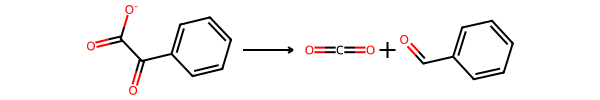

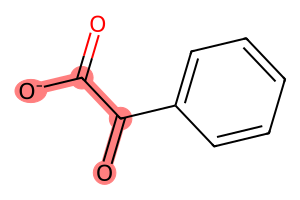

Mechanism: #1


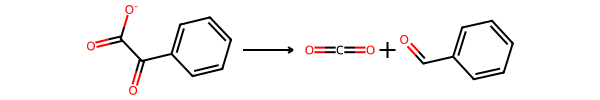

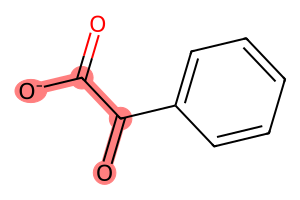

In [ ]:
display_mech_labeled_rxn(220)

Mechanism: #1


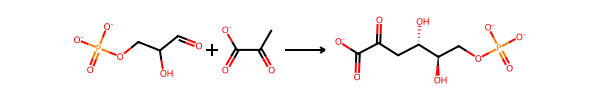

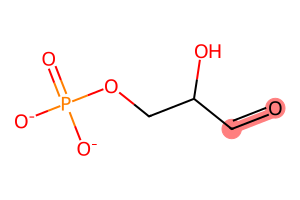

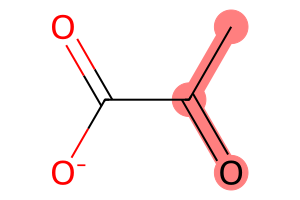

In [ ]:
display_mech_labeled_rxn(550)

Mechanism: #1


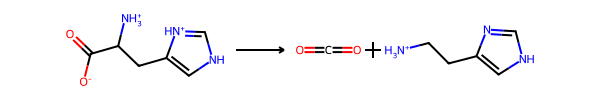

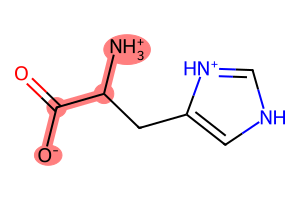

In [ ]:
display_mech_labeled_rxn(49)

In [ ]:
mm = pd.read_parquet(
    Path(filepaths.processed_data) / "mcsa" / "mapped_mech_labeled_reactions.parquet"
)
mm.head()

,entry_id,mechanism_id,smarts,am_smarts,rule,reaction_center,mech_atoms,enzyme_name,uniprot_id,ec,rule_id
0,1,1,NC(CCC(=O)O)C(=O)O>>NC(CCC(=O)O)C(=O)O,[NH2:5][CH:1]([CH2:3][CH2:2][C:4](=[O:9])[OH:1...,[#6:1]-[#6:2]-[#6:3]-[#6:4]>>[#6:1]-[#6:3]-[#6...,"1,2,3,4>>0,1,2,3","1,7,8,9>>",glutamate racemase,P56868,5.1.1.3,948
1,1,1,NC(CCC(=O)O)C(=O)O>>NC(CCC(=O)O)C(=O)O,[NH2:5][CH:1]([CH2:3][CH2:2][C:4](=[O:9])[OH:1...,[#6:1]-[#6:2]-[#6:3]-[#6:4]>>[#6:1]-[#6:3]-[#6...,"1,2,3,4>>0,1,2,3","1,7,8,9>>",glutamate racemase,P56868,5.1.1.3,948
2,2,2,*C(=O)NC1C(=O)N2C1SC(C)(C)C2C(=O)O.O>>*C(=O)NC...,[*:10][C:8](=[O:11])[NH:6][CH:4]1[C:2](=[O:5])...,[#6:1]-[#7:2].[#8:3]>>([#7:2].[#6:1]-[#8:3]),"5,7;0>>0,1,2","5,6,7;0>>",beta-lactamase (Class A),P62593,3.5.2.6,496
3,2,1,*C(=O)NC1C(=O)N2C1SC(C)(C)C2C(=O)O.O>>*C(=O)NC...,[*:10][C:8](=[O:11])[NH:6][CH:4]1[C:2](=[O:5])...,[#6:1]-[#7:2].[#8:3]>>([#7:2].[#6:1]-[#8:3]),"5,7;0>>0,1,2","5,6,7;0>>",beta-lactamase (Class A),P62593,3.5.2.6,496
4,6,1,NC(CCC(=O)NC(CSSCC(NC(=O)CCC(N)C(=O)O)C(=O)NCC...,[NH2:17][CH:14]([CH2:12][CH2:9][C:6](=[O:10])[...,[#16:1]-[#16:2].[#6:3]1=[#6:4]-[#7:5]-[#6:6]=[...,"9,10;3,4,5,45,46,47>>0;0;0,1,2,3,4,5","9,10;3,4,5,47>>",glutathione-disulfide reductase,P00390,1.8.1.7,146


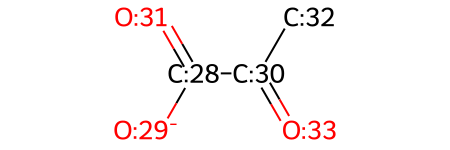

In [ ]:
Chem.MolFromSmarts('[#6:28](-[#8-:29])(-[#6:30](-[#6H3:32])=[#8:33])=[#8:31]')